In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)
    
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y))
        
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        
        self.loss_ = problem.solve(verbose=False)
        
        self.X_ = X
        self.y_ = y
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)
        
        return X @ self.w_

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv")

In [4]:
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


In [5]:
df_sc = df.pivot("state", "year", "cigsale")

df_sc.head()

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
state,,,,,,,,,,,,,,,,,,,,,
1,89.800003,95.400002,101.099998,102.900002,108.199997,111.699997,116.199997,117.099998,123.000000,121.400002,...,107.900002,109.099998,108.500000,107.099998,102.599998,101.400002,104.900002,106.199997,100.699997,96.199997
2,100.300003,104.099998,103.900002,108.000000,109.699997,114.800003,119.099998,122.599998,127.300003,126.500000,...,116.800003,126.000000,113.800003,108.800003,113.000000,110.699997,108.699997,109.500000,104.800003,99.400002
3,123.000000,121.000000,123.500000,124.400002,126.699997,127.099998,128.000000,126.400002,126.099998,121.900002,...,68.699997,67.500000,63.400002,58.599998,56.400002,54.500000,53.799999,52.299999,47.200001,41.599998
4,124.800003,125.500000,134.300003,137.899994,132.800003,131.000000,134.199997,132.000000,129.199997,131.500000,...,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.000000
5,120.000000,117.599998,110.800003,109.300003,112.400002,110.199997,113.400002,117.300003,117.500000,117.400002,...,86.699997,83.500000,79.099998,76.599998,79.300003,76.000000,75.900002,75.500000,73.400002,71.400002


In [6]:
sc_model = SyntheticControl()

y_co_pre = df.query("~after_treatment").query("~california").pivot("year", "state", "cigsale")
y_tr_pre = df.query("~after_treatment").query("california")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = df.query("~california").pivot("year", "state", "cigsale").dot(sc_weights)

att = df.query("california")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT: ", att.round(4))

SC ATT:  -19.5136


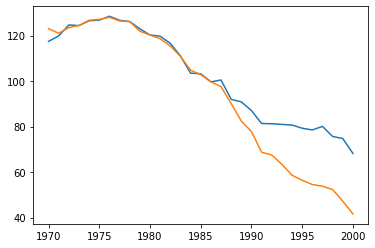

In [7]:
plt.plot(sc)
plt.plot(df_sc.loc[3]);

In [8]:
df_sc = df.query("~after_treatment").query("~california").pivot("year", "state", "cigsale")
all_geos = list(df_sc.columns)

y_mean_pre = df_sc.mean(axis=1)

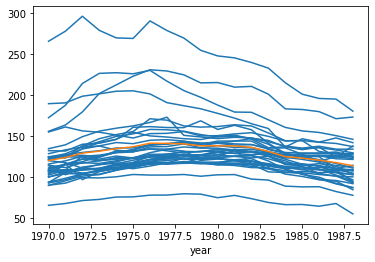

In [9]:
df_sc.plot(color="C0", legend=None)
plt.plot(y_mean_pre, color="C1")

In [10]:
from cvxpy.error import SolverError

np.random.seed(1)

def try_sc(geos, df_sc, y_mean_pre):
    model = SyntheticControl()
    y_co_pre = df_sc[geos]
    model.fit(y_co_pre, y_mean_pre)
    sc_weights = pd.Series(model.w_, index=y_co_pre.columns, name="sc_w")
    selected_geos = list(sc_weights[sc_weights.abs() > 1e-5].index)
    
    return {
        "geos": sorted(selected_geos),
        "loss": model.loss_
    }


def try_sc_st_combination(treatment_geos, df_sc, y_mean_pre):
    
    treatment_result = try_sc(treatment_geos, df_sc, y_mean_pre)
    remaining_geos = list(df_sc.drop(columns=treatment_result["geos"]).columns)
    
    control_result = try_sc(remaining_geos, df_sc, y_mean_pre)

    return {
        "st_geos": treatment_result["geos"],
        "sc_geos": control_result["geos"],
        "loss": treatment_result["loss"] + control_result["loss"],
    }
        

## Random Search

In [11]:
np.random.seed(123)

results = [
    try_sc_st_combination(np.random.choice(all_geos, 10, replace=False),
                          df_sc, 
                          y_mean_pre)
    for _ in range(1000)
]

min(map(lambda x: x.get("loss"), results))

1.0881790679599046

## Genetic Optimization

In [12]:
from scipy.optimize import differential_evolution

np.random.seed(123)

bounds  = [(0, 1) for _ in range(len(df_sc.columns))]
def gen_opt(x):
    n = 10
    geos = df_sc.iloc[:, list(np.argpartition(x, -n)[-n:])].columns
    return try_sc_st_combination(geos, df_sc, y_mean_pre)["loss"]

opt_result = differential_evolution(gen_opt, bounds, maxiter=5, popsize=5)

In [13]:
opt_result

     fun: 0.6779917637559285
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1179
     nit: 5
 success: False
       x: array([0.75850693, 0.58042525, 0.35312658, 0.17752842, 0.28766515,
       0.99947412, 0.33924905, 0.0636441 , 0.89929952, 0.22700994,
       0.72567478, 0.85614685, 0.63911068, 0.12299494, 0.40145186,
       0.84714601, 0.28928038, 0.38094207, 0.85600397, 0.069389  ,
       0.87670974, 0.64900987, 0.55056372, 0.60003314, 0.62120561,
       0.57769525, 0.94932882, 0.92084231, 0.60046146, 0.87857607,
       0.09592043, 0.17985356, 0.81333173, 0.62565503, 0.17839289,
       0.1313019 , 0.09595326, 0.6973101 ])

In [14]:
st = sorted(list(df_sc.iloc[:, list(np.argpartition(opt_result.x, -10)[-10:])].columns))
st

[7, 10, 13, 17, 20, 22, 28, 29, 31, 34]

In [15]:
try_sc(st, df_sc, y_mean_pre)["loss"]

0.677935524550849

In [16]:
try_sc(list(df_sc.drop(columns=st).columns), df_sc, y_mean_pre)["loss"]

5.6239205021309596e-05

## GA by Hand

In [17]:
from toolz import reduce
from operator import add

# np.random.seed(1)

def gen_population(geos, n_tr, pop_size=20):
    return [np.random.choice(geos, n_tr, replace=False) 
            for _ in range(pop_size)]


def top_k_fittest(population, df_sc, y_mean_pre, k=2):
    results = [try_sc_st_combination(geos, df_sc, y_mean_pre)
              for geos in population]
    
    return sorted(results, key=lambda x:x.get("loss"))[:k]


def get_top_geos(top_results):
    return set(reduce(add, map(lambda x: x["st_geos"], top_results)))
    
    
def mutate(top_geos, geos, n_mutations=5):
    mutations = np.random.choice([i for i in all_geos if i not in top_geos],
                                 n_mutations,
                                 replace=False)
    return top_geos.union(set(mutations))



def genetict_opt(all_geos,
                 df_sc,
                 y_mean_pre,
                 iterations=10,
                 n_tr=10,
                 parents=3,
                 pop_size=20,
                 n_mutations=3):
    
    population = gen_population(all_geos, n_tr=n_tr, pop_size=pop_size)
    
    best_results = []
    
    for _ in range(iterations):
        top_results = top_k_fittest(population, df_sc, y_mean_pre, k=parents)
        top_geos = get_top_geos(top_results)
        top_with_mutations = mutate(top_geos, all_geos, n_mutations=n_mutations)
        population = gen_population(list(top_with_mutations), n_tr=n_tr, pop_size=pop_size)
        
        best_results += [top_results[0]]
        
    return best_results

final_result = genetict_opt(all_geos, df_sc, y_mean_pre, n_tr=10, pop_size=20, iterations=50, parents=3)

In [18]:
min(map(lambda x: x.get("loss"), final_result))
# final_result

0.4665395692313691

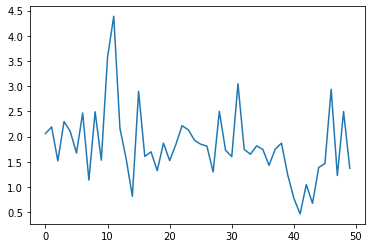

In [19]:
plt.plot(list(map(lambda x: x.get("loss"), final_result)))